# Notes:

# Imports:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

In [2]:
import statsmodels.api as sm

from matplotlib import __version__ as mpl_ver
from ipympl import __version__ as ipy_ver

In [3]:
%matplotlib widget

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


## Helpers:

In [74]:
# ═════════════ Helper functions ═════════════
def plane_params_from_vectors(vA, vB, origin):
    return np.cross(vA, vB), origin

def intersection_with_box(normal, origin, xlim, ylim, zlim):
    bounds = [(xlim[0], xlim[1]), (ylim[0], ylim[1]), (zlim[0], zlim[1])]
    pts = []
    # Faces parallel to xy
    for xi in bounds[0]:
        for yi in bounds[1]:
            if abs(normal[2]) > 1e-10:
                zi = (-normal[0]*(xi-origin[0]) - normal[1]*(yi-origin[1]))/normal[2] + origin[2]
                if zlim[0]-1e-12 <= zi <= zlim[1]+1e-12:
                    pts.append([xi, yi, zi])
    # Faces parallel to xz
    for xi in bounds[0]:
        for zi in bounds[2]:
            if abs(normal[1]) > 1e-10:
                yi = (-normal[0]*(xi-origin[0]) - normal[2]*(zi-origin[2]))/normal[1] + origin[1]
                if ylim[0]-1e-12 <= yi <= ylim[1]+1e-12:
                    pts.append([xi, yi, zi])
    # Faces parallel to yz
    for yi in bounds[1]:
        for zi in bounds[2]:
            if abs(normal[0]) > 1e-10:
                xi = (-normal[1]*(yi-origin[1]) - normal[2]*(zi-origin[2]))/normal[0] + origin[0]
                if xlim[0]-1e-12 <= xi <= xlim[1]+1e-12:
                    pts.append([xi, yi, zi])
    pts = np.unique(np.round(pts, 8), axis=0)
    if len(pts) < 3:
        return pts

    pts_center = pts - origin
    tmpv = np.array([1,0,0]) if abs(normal[0]) < 0.5 else np.array([0,1,0])
    xdir = np.cross(normal, tmpv).astype(float)     #  <<-- float cast fixes UFuncTypeError
    xdir /= np.linalg.norm(xdir)
    ydir = np.cross(normal, xdir).astype(float)
    ydir /= np.linalg.norm(ydir)
    hull_pts_2d = np.c_[pts_center @ xdir, pts_center @ ydir]
    try:
        hull = ConvexHull(hull_pts_2d)
        return pts[hull.vertices]
    except:
        return pts

def plane_axis_intersections(n, o, xlim, ylim, zlim):
    out = []
    if n[0] != 0:
        xs = (-n[1]*(0-o[1]) - n[2]*(0-o[2]))/n[0] + o[0]
        if xlim[0] <= xs <= xlim[1]: out.append([xs,0,0])
    if n[1] != 0:
        ys = (-n[0]*(0-o[0]) - n[2]*(0-o[2]))/n[1] + o[1]
        if ylim[0] <= ys <= ylim[1]: out.append([0,ys,0])
    if n[2] != 0:
        zs = (-n[0]*(0-o[0]) - n[1]*(0-o[1]))/n[2] + o[2]
        if zlim[0] <= zs <= zlim[1]: out.append([0,0,zs])
    return out

def plane_plane_intersection(n1, p1, n2, p2):
    d = np.cross(n1, n2)
    if np.linalg.norm(d) < 1e-10:
        return None, None
    d = d / np.linalg.norm(d)
    d1, d2 = n1 @ p1, n2 @ p2
    idx = np.argmax(np.abs(d))
    oth = [i for i in range(3) if i != idx]
    A = np.array([[n1[oth[0]], n1[oth[1]]],
                  [n2[oth[0]], n2[oth[1]]]])
    b = np.array([d1, d2])
    try:
        sol = np.linalg.solve(A, b)
        pt = np.zeros(3)
        pt[oth] = sol
        return pt, d
    except:
        return None, None

def project_point_to_plane(pt, normal, origin):
    dist = (normal @ (pt-origin))/np.linalg.norm(normal)
    return pt - dist*normal/np.linalg.norm(normal)

def angle_between_vectors(a,b):
    a, b = a/np.linalg.norm(a), b/np.linalg.norm(b)
    return np.arccos(np.clip(a@b, -1, 1))
    
def draw_angle_arc(ax, start, v1, v2, radius=0.8, color='k', label=None, linestyle=':', arc_lw = 2, arrow=True):
    """
        arrow = true -> makes the diagonal arc directional, in the sense that it goes from v1 to v2.
    """
    v1u, v2u = v1/np.linalg.norm(v1), v2/np.linalg.norm(v2)
    ang  = angle_between_vectors(v1, v2)
    n    = np.cross(v1u, v2u)
    if np.linalg.norm(n) < 1e-10: return
    n = n/np.linalg.norm(n)
    pts = []
    # for arrow, we want the last segment direction
    for t in np.linspace(0, ang, 30):
        rot = (v1u*np.cos(t) + np.cross(n, v1u)*np.sin(t) + n*(n@v1u)*(1-np.cos(t)))
        pts.append(start + radius*rot)
    pts = np.asarray(pts)
    ax.plot(pts[:,0], pts[:,1], pts[:,2], color=color, linestyle=linestyle,
            lw=arc_lw, label=label)
    
    if arrow and len(pts)>=2:
        # calculate direction for arrowhead at the tip
        tip = pts[-1]
        tail = pts[-2]
        direction = tip - tail
        direction = direction/np.linalg.norm(direction) * 0.1 * radius  # shorter arrow shaft

        ax.quiver(
            *tail, *direction, color=color, lw=arc_lw, arrow_length_ratio=2.5, alpha=1, linestyle='-'
        )

def dedup_legend(ax):
    h,l = ax.get_legend_handles_labels()
    uniq = dict(zip(l,h))
    ax.legend(uniq.values(), uniq.keys())

In [6]:
def expand_box_to_hit_sides(n, o, xlim, ylim, zlim):
    """
    Expand limits so the plane intersects the cube at:
      - x = min(xlim)  (negative x side)
      - y = max(ylim)  (positive y side)
      - z = min(zlim)  (negative z side)
    """
    x0, x1 = xlim
    y0, y1 = ylim
    z0, z1 = zlim

    # helper to compute intersection with a fixed face
    def intersect_with_plane(coord, axis):
        pt = [0.0, 0.0, 0.0]
        if axis == 0:  # x fixed
            pt[0] = coord
            # solve for y,z
            if abs(n[2]) > 1e-10:
                # use y=y1, solve z
                pt[1] = y1
                pt[2] = (-n[0]*(coord-o[0]) - n[1]*(y1-o[1]))/n[2] + o[2]
                return pt
        if axis == 1:  # y fixed
            pt[1] = coord
            if abs(n[2]) > 1e-10:
                # use x=x0, solve z
                pt[0] = x0
                pt[2] = (-n[0]*(x0-o[0]) - n[1]*(coord-o[1]))/n[2] + o[2]
                return pt
        if axis == 2:  # z fixed
            pt[2] = coord
            if abs(n[0]) > 1e-10:
                # use y=y1, solve x
                pt[1] = y1
                pt[0] = (-n[1]*(y1-o[1]) - n[2]*(coord-o[2]))/n[0] + o[0]
                return pt
        return None

    # find intersections
    ix = intersect_with_plane(x0, 0)
    iy = intersect_with_plane(y1, 1)
    iz = intersect_with_plane(z0, 2)

    # expand limits so all intersections fit
    xs, ys, zs = [x0, x1], [y0, y1], [z0, z1]
    for pt in [ix, iy, iz]:
        if pt is not None:
            xs.append(pt[0])
            ys.append(pt[1])
            zs.append(pt[2])

    return (min(xs), max(xs)), (min(ys), max(ys)), (min(zs), max(zs))

In [7]:
plt.close('all')

# Run:

## hyperparams:

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull

# ─────────── Fixed view ────────────
elev, azim = 30, -65

# ─────────── Vectors / points ──────
origin = np.zeros(3)

v1 = np.array([1, 1, 1])
v2 = np.array([0, 2, -1.5])

# Copy v1, v2 and zero-out the y–component → sample plane
v4, v5 = v1.copy(), v2.copy()
v4[1] = 0
v5[1] = 0

# Point Y (to be projected)
v3 = np.array([3, 1, 2])
# ─────────── Box limits ────────────
xlim = (-2, 3)
ylim = (-2, 3)
zlim = (-2, 3)

# bkgrd pane color
bkgrd_color = 0.98

print(">>> Snippet 1 loaded (helpers ready).")

>>> Snippet 1 loaded (helpers ready).


In [9]:
X0_name = 'Intercept'
X1_name = 'Feature 1'

In [10]:
plt.close('all')

## Subplot 1:

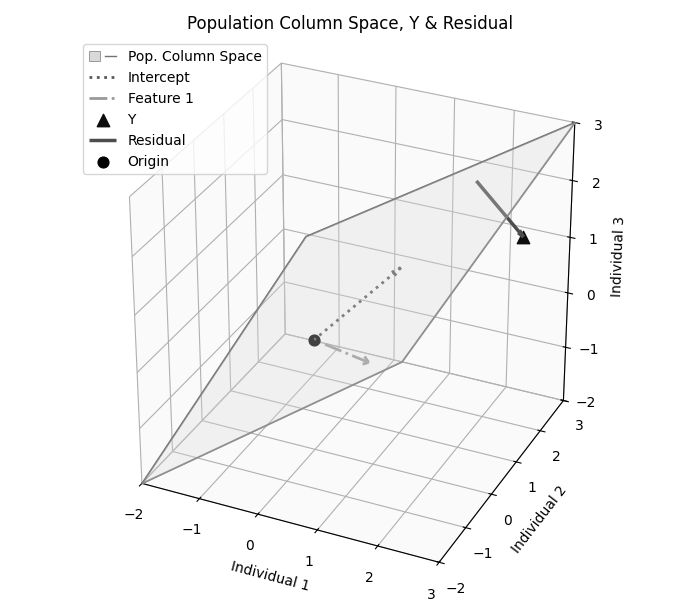

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# --- Geometry specific to this plot (unchanged) ---
pop_n, pop_o   = plane_params_from_vectors(v1, v2, origin)
pop_poly       = intersection_with_box(pop_n, pop_o, xlim, ylim, zlim)
pop_axes_pts   = plane_axis_intersections(pop_n, pop_o, xlim, ylim, zlim)
proj_Y         = project_point_to_plane(v3, pop_n, origin)
residual       = v3 - proj_Y

# --- Plot ---
fig = plt.figure(figsize=(7, 6))
ax  = fig.add_subplot(111, projection='3d')

# Population plane (light grey face, thin edge)
pop_plane_poly = Poly3DCollection([pop_poly],
                     facecolors='0.85',
                     edgecolor='0.55',
                     linewidths=0.6,
                     alpha=0.30)
ax.add_collection3d(pop_plane_poly)
poly = np.vstack([pop_poly, pop_poly[0]])
ax.plot(poly[:,0], poly[:,1], poly[:,2],
        color='0.45', lw=1)              # << thinner outline, solid

# Axes intersections (dashed black)
for p in pop_axes_pts:
    ax.plot([0, p[0]], [0, p[1]], [0, p[2]],
            linestyle='--', color='0.20', lw=2)

# Basis vectors
ax.quiver(*origin, *v1, color='0.35', linestyle=':',  lw=2,
          arrow_length_ratio=.1, label=X0_name)
ax.quiver(*origin, *v2, color='0.60', linestyle='-.', lw=2,
          arrow_length_ratio=.1, label=X1_name)

# Y point – black triangle
ax.scatter(*v3, color='0.05', s=80, marker='^', label='Y')

# Residual vector – dark grey (now visually clearer)
ax.quiver(*proj_Y, *residual, color='0.30', lw=2.5,
          arrow_length_ratio=.1, label='Residual')

# Origin – black circle
ax.scatter(*origin, color='0.00', s=60, marker='o', label='Origin')

ax.view_init(elev=elev, azim=azim)
for a in 'xyz':
    getattr(ax, f'set_{a}label')(f'Individual {["x","y","z"].index(a)+1}')
ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
ax.set_box_aspect([1,1,1])

# --- Custom legend handle for Population Plane ---
pop_plane_patch = Patch(
    facecolor='0.85', 
    edgecolor='0.55', 
    linewidth=0.6
)
pop_plane_outline = Line2D([0], [0], 
    color='0.45', lw=1, linestyle='-'
)
pop_plane_handle = (pop_plane_patch, pop_plane_outline)

# Gather other legend items
handles, labels = ax.get_legend_handles_labels()
custom_handles = [pop_plane_handle]
custom_labels = ['Pop. Column Space']

# Add remaining handles (avoid duplicates)
for h, l in zip(handles, labels):
    if l not in custom_labels:
        custom_handles.append(h)
        custom_labels.append(l)

from matplotlib.legend_handler import HandlerTuple
ax.legend(custom_handles, custom_labels, handler_map={tuple: HandlerTuple(ndivide=None)})

ax.xaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))
ax.yaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))
ax.zaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))

ax.set_title('Population Column Space, Y & Residual')
plt.tight_layout()
plt.show()
plt.savefig('cosine_similarity_1', dpi=600)

## Subplot 2:

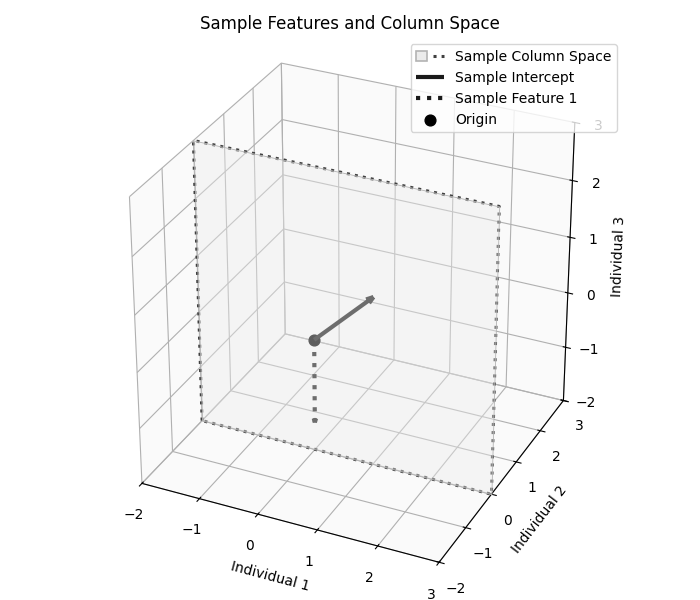

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# --- Geometry specific to this plot (unchanged) ------------------------
samp_n, samp_o  = plane_params_from_vectors(v4, v5, origin)
samp_poly       = intersection_with_box(samp_n, samp_o, xlim, ylim, zlim)
samp_axes_pts   = plane_axis_intersections(samp_n, samp_o, xlim, ylim, zlim)

# --- Plot --------------------------------------------------------------
fig = plt.figure(figsize=(7, 6))
ax  = fig.add_subplot(111, projection='3d')

# Sample plane ----------------------------------------------------------
plane_poly = Poly3DCollection(
    [samp_poly],
    facecolors='0.92',
    edgecolor='0.70',
    linewidths=0.6,
    alpha=0.40
)
ax.add_collection3d(plane_poly)
poly = np.vstack([samp_poly, samp_poly[0]])

# Distinct outline: dotted, darker, thicker
ax.plot(poly[:,0], poly[:,1], poly[:,2],
        color='0.25', lw=2.2, linestyle=':')    # No label here!

# Axes-intersection helpers ---------------------------------------------
for p in samp_axes_pts:
    ax.plot([0, p[0]], [0, p[1]], [0, p[2]],
            linestyle='--', color='0.20', lw=2)

# Sample basis vectors --------------------------------------------------
ax.quiver(*origin, *v4,
          color='0.1', linestyle='-',   lw=3,
          arrow_length_ratio=.1, label=f'Sample {X0_name}')
ax.quiver(*origin, *v5,
          color='0.1', linestyle='dotted',  lw=3,
          arrow_length_ratio=.1, label=f'Sample {X1_name}')

# Origin – solid black dot
ax.scatter(*origin, color='0.00', s=60, marker='o', label='Origin')

ax.view_init(elev=elev, azim=azim)
for a in 'xyz':
    getattr(ax, f'set_{a}label')(f'Individual {['x','y','z'].index(a)+1}')
ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
ax.set_box_aspect([1,1,1])

# --- Custom legend: Patch + Line2D --------------------------------------
sample_plane_patch = Patch(
    facecolor='0.92',
    edgecolor='0.70',  # subtle edge on polygon faces
    linewidth=1.2
)
sample_plane_outline = Line2D([0], [0],
    color='0.25', lw=2.2, linestyle=':', label='Sample Plane (fill + dotted outline)'
)
handles, labels = ax.get_legend_handles_labels()
custom_handles = [
    (sample_plane_patch, sample_plane_outline)  # tuple: both fill and outline
]
custom_labels = ['Sample Column Space']
# Add the other handles (Sample X0, Sample X1, Origin, etc)
for h, l in zip(handles, labels):
    if l not in custom_labels:  # Avoid duplicates
        custom_handles.append(h)
        custom_labels.append(l)

from matplotlib.legend_handler import HandlerTuple

ax.legend(
    custom_handles, custom_labels,
    handler_map = {tuple: HandlerTuple(ndivide=None)},
    loc='best'
)

ax.xaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))
ax.yaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))
ax.zaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))

ax.set_title('Sample Features and Column Space')
plt.tight_layout()
plt.show()
plt.savefig('cosine_similarity_2', dpi=600)

## Subplot 3:

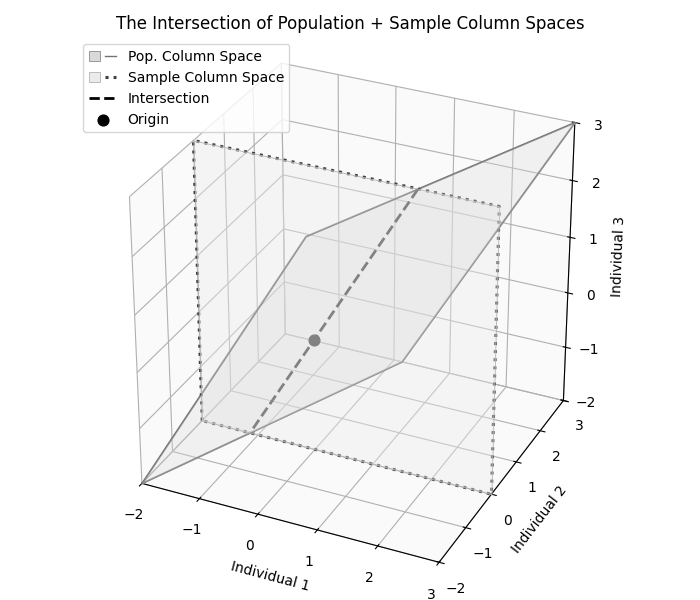

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

# --- Geometry specific to this plot ---
pop_n, pop_o   = plane_params_from_vectors(v1, v2, origin)
samp_n, samp_o = plane_params_from_vectors(v4, v5, origin)
pop_poly       = intersection_with_box(pop_n,  pop_o,  xlim, ylim, zlim)
samp_poly      = intersection_with_box(samp_n, samp_o, xlim, ylim, zlim)
int_pt, int_dir = plane_plane_intersection(pop_n, pop_o, samp_n, samp_o)

# --- Plot ---
fig = plt.figure(figsize=(7,6))
ax  = fig.add_subplot(111, projection='3d')

# Population plane
pop_plane_poly = Poly3DCollection([pop_poly], facecolors='0.85', edgecolor='0.55',
                                  linewidths=0.6, alpha=0.3)
ax.add_collection3d(pop_plane_poly)
pop_poly_outline = np.vstack([pop_poly, pop_poly[0]])
ax.plot(pop_poly_outline[:,0], pop_poly_outline[:,1], pop_poly_outline[:,2], 
        color='0.45', lw=1)   # solid outline, thin

# Sample plane
samp_plane_poly = Poly3DCollection([samp_poly], facecolors='0.92', edgecolor='0.70',
                                   linewidths=0.6, alpha=0.4)
ax.add_collection3d(samp_plane_poly)
samp_poly_outline = np.vstack([samp_poly, samp_poly[0]])
ax.plot(samp_poly_outline[:,0], samp_poly_outline[:,1], samp_poly_outline[:,2], 
        color='0.25', lw=2.2, linestyle=':')   # dotted outline, distinct

# Intersection line (dashed black)
if int_pt is not None:
    t = np.linspace(-10,10,800)[:,None]
    lp = int_pt + t*int_dir
    m = ((xlim[0]<=lp[:,0])&(lp[:,0]<=xlim[1])&
         (ylim[0]<=lp[:,1])&(lp[:,1]<=ylim[1])&
         (zlim[0]<=lp[:,2])&(lp[:,2]<=zlim[1]))
    lp = lp[m]
    ax.plot(lp[:,0], lp[:,1], lp[:,2], '0.00', linestyle='--', lw=2, label='Intersection')

ax.scatter(*origin, color='0.00', s=60, marker='o', label='Origin')
ax.view_init(elev=elev, azim=azim)
for a in 'xyz':
    getattr(ax, f'set_{a}label')(f'Individual {["x","y","z"].index(a)+1}')
ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
ax.set_box_aspect([1,1,1])

# Custom legend handles (greyscale-friendly, planes show fill and outline)
pop_plane_patch    = Patch(facecolor='0.85', edgecolor='0.55', linewidth=0.6)
pop_plane_outline  = Line2D([0], [0], color='0.45', lw=1, linestyle='-')
sample_plane_patch = Patch(facecolor='0.92', edgecolor='0.70', linewidth=0.6)
sample_plane_outline = Line2D([0], [0], color='0.25', lw=2.2, linestyle=':')

custom_handles = [
    (pop_plane_patch, pop_plane_outline),
    (sample_plane_patch, sample_plane_outline)
]
custom_labels = ['Pop. Column Space', 'Sample Column Space']

# Add any other legend entries (Intersection, Origin)
handles, labels = ax.get_legend_handles_labels()
for h, l in zip(handles, labels):
    if l not in custom_labels:
        custom_handles.append(h)
        custom_labels.append(l)

ax.legend(custom_handles, custom_labels, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='best')

ax.set_title('The Intersection of Population + Sample Column Spaces')

ax.xaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))
ax.yaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))
ax.zaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))

plt.tight_layout()
plt.show()
plt.savefig('cosine_similarity_3', dpi=600)

## Subplot 4:

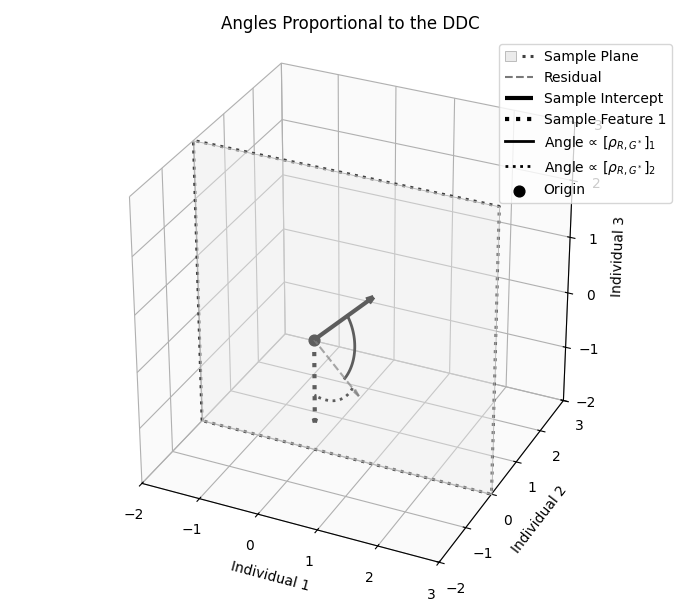

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

# --- Geometry specific to this plot ---
pop_n, pop_o = plane_params_from_vectors(v1, v2, origin)
proj_Y       = project_point_to_plane(v3, pop_n, origin)
residual     = v3 - proj_Y
samp_n, samp_o = plane_params_from_vectors(v4, v5, origin)
samp_poly    = intersection_with_box(samp_n, samp_o, xlim, ylim, zlim)

# --- Plot ---
fig = plt.figure(figsize=(7,6))
ax  = fig.add_subplot(111, projection='3d')

# Sample plane: very light, semi-transparent fill, distinct dotted dark outline
samp_plane_poly = Poly3DCollection([samp_poly], facecolors='0.92', edgecolor='0.70',
                                   linewidths=0.6, alpha=0.4)
ax.add_collection3d(samp_plane_poly)
samp_poly_outline = np.vstack([samp_poly, samp_poly[0]])
ax.plot(samp_poly_outline[:,0], samp_poly_outline[:,1], samp_poly_outline[:,2], 
        color='0.25', lw=2.2, linestyle=':')

# Residual vector: dark, dashed, thinner
ax.quiver(*origin, *residual, color='0.25', linestyle='--', alpha=.7,
          lw=1.5, arrow_length_ratio=.1, label='Residual')

# Sample X0: medium-dark, solid
ax.quiver(*origin, *v4, color='0.00', linestyle='-', lw=3,
          arrow_length_ratio=.1, label=f'Sample {X0_name}')

# Sample X1: light, dash-dot, thicker
ax.quiver(*origin, *v5, color='0.00', linestyle='dotted', lw=3,
          arrow_length_ratio=.1, label=f'Sample {X1_name}')

# Angle arcs: match vectors
draw_angle_arc(ax, origin, residual, v4, radius=.8, color='0.00', linestyle='-',
               label=r'Angle ∝ $[\rho_{R,G^*}]_1$')
draw_angle_arc(ax, origin, residual, v5, radius=1.0, color='0.00', linestyle='dotted',
               label=r'Angle ∝ $[\rho_{R,G^*}]_2$')

ax.scatter(*origin, color='0.00', s=60, marker='o', label='Origin')
ax.view_init(elev=elev, azim=azim)
for a in 'xyz':
    getattr(ax, f'set_{a}label')(f'Individual {["x","y","z"].index(a)+1}')
ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
ax.set_box_aspect([1,1,1])

# ---- Custom legend handle for Sample Plane -----
sample_plane_patch = Patch(facecolor='0.92', edgecolor='0.70', linewidth=0.6)
sample_plane_outline = Line2D([0], [0], color='0.25', lw=2.2, linestyle=':')
custom_handles = [(sample_plane_patch, sample_plane_outline)]
custom_labels = ['Sample Plane']

# Add remaining handles (avoid duplicates)
handles, labels = ax.get_legend_handles_labels()
for h, l in zip(handles, labels):
    if l not in custom_labels:
        custom_handles.append(h)
        custom_labels.append(l)

ax.legend(custom_handles, custom_labels, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='best', bbox_to_anchor=(1.1, 1))

ax.set_title('Angles Proportional to the DDC')

ax.xaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))
ax.yaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))
ax.zaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))

plt.tight_layout()
plt.show()
plt.savefig('cosine_similarity_4', dpi=600)

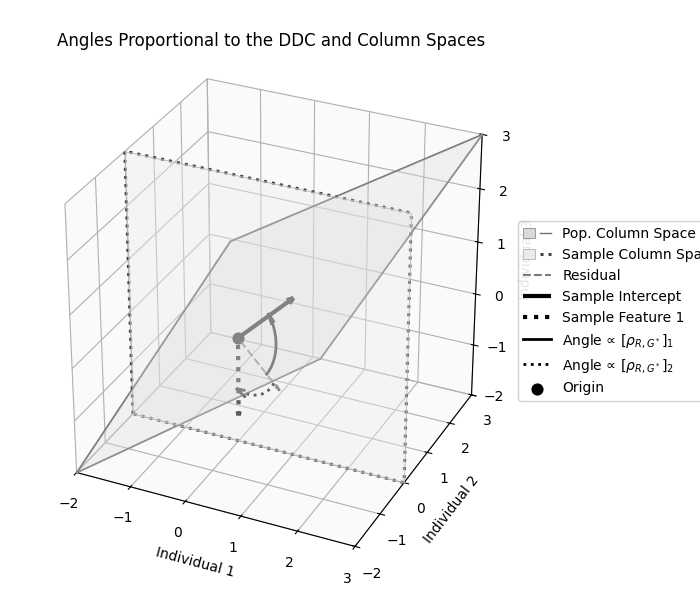

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

# --- Geometry specific to this plot ---
pop_n, pop_o = plane_params_from_vectors(v1, v2, origin)
proj_Y       = project_point_to_plane(v3, pop_n, origin)
residual     = v3 - proj_Y
samp_n, samp_o = plane_params_from_vectors(v4, v5, origin)

# Calculate plane intersections with the plot box
pop_poly     = intersection_with_box(pop_n, pop_o, xlim, ylim, zlim)
samp_poly    = intersection_with_box(samp_n, samp_o, xlim, ylim, zlim)

# Calculate intersection line between population and sample planes
int_pt, int_dir = plane_plane_intersection(pop_n, pop_o, samp_n, samp_o)

# --- Plot ---
fig = plt.figure(figsize=(7,6))
ax  = fig.add_subplot(111, projection='3d')

# Population plane: medium gray, semi-transparent fill, solid outline
pop_plane_poly = Poly3DCollection([pop_poly], facecolors='0.85', edgecolor='0.55',
                                  linewidths=0.6, alpha=0.3)
ax.add_collection3d(pop_plane_poly)
pop_poly_outline = np.vstack([pop_poly, pop_poly[0]])
ax.plot(pop_poly_outline[:,0], pop_poly_outline[:,1], pop_poly_outline[:,2], 
        color='0.45', lw=1)   # solid outline, thin

# Sample plane: very light, semi-transparent fill, distinct dotted dark outline
samp_plane_poly = Poly3DCollection([samp_poly], facecolors='0.92', edgecolor='0.70',
                                   linewidths=0.6, alpha=0.4)
ax.add_collection3d(samp_plane_poly)
samp_poly_outline = np.vstack([samp_poly, samp_poly[0]])
ax.plot(samp_poly_outline[:,0], samp_poly_outline[:,1], samp_poly_outline[:,2], 
        color='0.25', lw=2.2, linestyle=':')

# Residual vector: dark, dashed, thinner
ax.quiver(*origin, *residual, color='0.25', linestyle='--', alpha=.7,
          lw=1.5, arrow_length_ratio=.1, label='Residual')

# Sample X0: medium-dark, solid
ax.quiver(*origin, *v4, color='0.00', linestyle='-', lw=3,
          arrow_length_ratio=.1, label=f'Sample {X0_name}')

# Sample X1: light, dash-dot, thicker
ax.quiver(*origin, *v5, color='0.00', linestyle='dotted', lw=3,
          arrow_length_ratio=.1, label=f'Sample {X1_name}')

# Angle arcs: match vectors
draw_angle_arc(ax, origin, residual, v4, radius=.8, color='0.00', linestyle='-',
               label=r'Angle ∝ $[\rho_{R,G^*}]_1$', arrow=True)
draw_angle_arc(ax, origin, residual, v5, radius=1.0, color='0.00', linestyle='dotted',
               label=r'Angle ∝ $[\rho_{R,G^*}]_2$', arrow=True)

ax.scatter(*origin, color='0.00', s=60, marker='o', label='Origin')

ax.view_init(elev=elev, azim=azim)
for a in 'xyz':
    getattr(ax, f'set_{a}label')(f'Individual {["x","y","z"].index(a)+1}')
ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
ax.set_box_aspect([1,1,1])

# ---- Custom legend handles for both planes -----
pop_plane_patch    = Patch(facecolor='0.85', edgecolor='0.55', linewidth=0.6)
pop_plane_outline  = Line2D([0], [0], color='0.45', lw=1, linestyle='-')
sample_plane_patch = Patch(facecolor='0.92', edgecolor='0.70', linewidth=0.6)
sample_plane_outline = Line2D([0], [0], color='0.25', lw=2.2, linestyle=':')

custom_handles = [
    (pop_plane_patch, pop_plane_outline),
    (sample_plane_patch, sample_plane_outline)
]
custom_labels = ['Pop. Column Space', 'Sample Column Space']

# Add remaining handles (avoid duplicates)
handles, labels = ax.get_legend_handles_labels()
for h, l in zip(handles, labels):
    if l not in custom_labels:
        custom_handles.append(h)
        custom_labels.append(l)

# --- Adaptive legend placement ---
if abs(elev - 30) < 5 and abs(azim - (-65)) < 5:
    # Preferred view → legend middle right, slightly overlapping axes if needed
    legend = ax.legend(
        custom_handles, custom_labels,
        handler_map={tuple: HandlerTuple(ndivide=None)},
        loc='center left',
        bbox_to_anchor=(0.98, 0.5),   # <1 keeps legend fully inside figure
        borderaxespad=0.,
        frameon=True, fancybox=True, framealpha=0.9
    )
else:
    # Default: place inside plot
    legend = ax.legend(
        custom_handles, custom_labels,
        handler_map={tuple: HandlerTuple(ndivide=None)},
        loc='upper right',
        frameon=True, fancybox=True, framealpha=0.9
    )


# ax.legend(custom_handles, custom_labels, handler_map={tuple: HandlerTuple(ndivide=None)}, loc='best', bbox_to_anchor=(1.1, 1))


ax.set_title('Angles Proportional to the DDC and Column Spaces')

ax.xaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))
ax.yaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))
ax.zaxis.set_pane_color((bkgrd_color, bkgrd_color, bkgrd_color, 1.0))

plt.tight_layout()
plt.show()
# plt.savefig('cosine_similarity_4b', dpi=600, bbox_inches='tight')

In [70]:
plt.close('all')